In [5]:
using System;
using System.Threading;
using System.Diagnostics;

public class DefiniteIntegral
{
    public static (double result, long time) Calculate(double start, double end, Func<double, double> function, double stepSize, int threadCount)
    {
        double result = 0.0;
        Barrier barrier = new Barrier(threadCount + 1);
        double interval = (end - start) / threadCount;
        Stopwatch stopwatch = new Stopwatch();
        stopwatch.Start();
        List<Thread> threads = new List<Thread>();
        for (int i = 0; i < threadCount; i++)
        {
            int threadIndex = i;
            Thread thread = new Thread(() =>
            {
                double pointA = start + threadIndex * interval;
                double pointB = start + (threadIndex + 1) * interval;
                double threadResult = 0.0;
                for (double currentPoint = pointA; currentPoint < pointB; currentPoint += stepSize)
                {
                    double nextPoint = currentPoint + stepSize;
                    if (nextPoint > pointB)
                    {
                        nextPoint = pointB;
                    }
                    threadResult += (function(currentPoint) + function(nextPoint)) * (nextPoint - currentPoint) / 2;
                }

                result += threadResult;

                barrier.SignalAndWait();
            });
            threads.Add(thread);
        }
        foreach (var thread in threads)
        {
            thread.Start();
        }
        barrier.SignalAndWait();
        stopwatch.Stop();
        long time = stopwatch.ElapsedTicks;
        return (result, time);
    }
}


Installed Packages ScottPlot, 5.0.35 xunit, 2.8.1

Thread count: 1, Time: 275886 
Thread count: 2, Time: 146484 
Thread count: 3, Time: 133130 
Thread count: 4, Time: 140180 
Thread count: 5, Time: 108775 
Thread count: 6, Time: 100544 
Thread count: 7, Time: 102625 
Thread count: 8, Time: 99849 
Thread count: 9, Time: 94679 
Thread count: 10, Time: 95413 
Thread count: 11, Time: 100314 
Thread count: 12, Time: 100489 
Thread count: 13, Time: 96321 
Thread count: 14, Time: 99248 
Thread count: 15, Time: 115853 
Thread count: 16, Time: 114908 
Thread count: 17, Time: 114586 
Thread count: 18, Time: 115908 
Thread count: 19, Time: 108177 
Thread count: 20, Time: 110997 
Thread count: 21, Time: 106689 
Thread count: 22, Time: 99188 
Thread count: 23, Time: 107889 
Thread count: 24, Time: 118024 
Thread count: 25, Time: 105227 
Thread count: 26, Time: 107006 
Thread count: 27, Time: 116544 
Thread count: 28, Time: 104407 
Thread count: 29, Time: 115196 
Thread count: 30, Time: 128949 
Thread count: 31, Time: 316367 
Thread count: 32, Time:


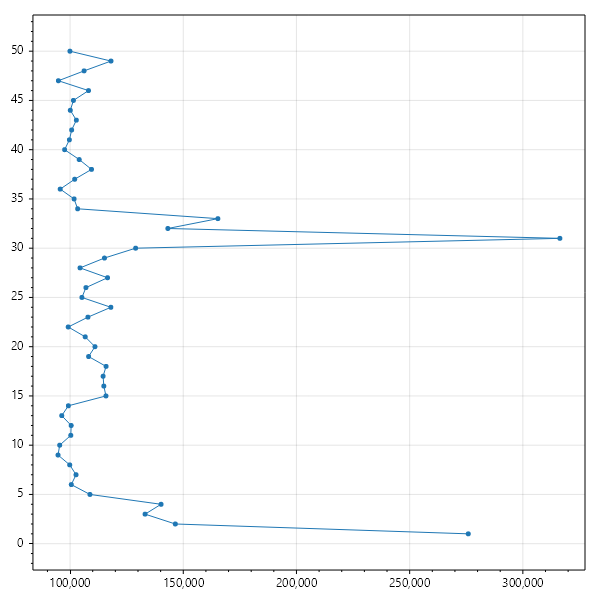

In [6]:
#r "nuget: xunit, 2.8.1"
#r "nuget:ScottPlot, 5.0.35"

using Xunit;
using Microsoft.DotNet.Interactive.Formatting;

Formatter.Register(typeof(ScottPlot.Plot), (p, w) =>
    w.Write(((ScottPlot.Plot)p).GetImageHtml(600, 600)), HtmlFormatter.MimeType);

var LinearFunction = (double x) => x;
var SineFunction = (double x) => Math.Sin(x);
List<int> threadCounts = new List<int>();
List<long> executionTimes = new List<long>();

Assert.Equal(0, DefiniteIntegral.Calculate(-100, 100, SineFunction, 1e-4, 8).result, 1e-4);

for (int i = 1; i <= 50; i += 1)
{
    var (res, t) = DefiniteIntegral.Calculate(-100, 100, SineFunction, 1e-4, i);
    threadCounts.Add(i);
    executionTimes.Add(t);
    Console.WriteLine($"Thread count: {i}, Time: {t} ");
}

double[] dataThreads = threadCounts.Select(x => (double)x).ToArray();
double[] dataTimes = executionTimes.Select(x => (double)x).ToArray();

ScottPlot.Plot plt = new();
plt.Add.Scatter(dataTimes, dataThreads);
plt